# Predicting Heart Disease -- Final

## https://www.kaggle.com/ronitf/heart-disease-uci,

## ライブラリの読み込み

In [3]:
# OS（オペレーティングシステム）に依存した機能を使うための標準ライブラリ
import os
import gc
import sys # Pythonのインタプリタや実行環境に関する情報を扱うためのライブラリ
#os.getcwd() # 現在のディレクトリを返す

In [4]:
# Library の読み込み
import sys # Pythonのインタプリタや実行環境に関する情報を扱うためのライブラリ
import pandas as pd # データを扱うための標準的なライブラリ
import numpy as np # 多次元配列を扱う数値演算ライブラリ
import scipy as sp # 高度な科学計算を行うためのライブラリ
import sklearn # 機械学習のライブラリ

import lightgbm as lgbm  #conda install -c conda-forge lightgbm

import matplotlib.pyplot as plt # グラフを描画するライブラリ
%matplotlib inline
# jupyter内に描画

## データファイルの読み込

In [5]:
# CSVファイルの読み込み
df = pd.read_csv("./data/heart.csv") # df = data frame の略
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [6]:
df.shape # pandas の dataframe の行と列の表示

(303, 14)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null int64
target      303 non-null int64
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


## データの標準化  ⇒ これが正解率を上げるのに大きく寄与

https://helve-python.hatenablog.jp/entry/scikitlearn-scale-conversion

データの平均値と分散を変換する操作を標準化と呼ぶ。平均値を0, 分散を1とすることが多い。
変換操作は以下の式で表される。

Y=X−μσ

ここで、Yは変換後のデータ、Xは変換前のデータである。
また、μ,σは、それぞれXの平均、分散である。
Scikit-learnで標準化は、関数としてはscale, クラスとしてはStandardScalerという名前で用意されている。

https://aizine.ai/preprocessing0614/

スケール変換は個々の特徴量の平均が０、標準偏差が１になるように変換して特徴量を標準正規分布に近似する。多くの機械学習のアルゴリズムにはこのStandardScalerを用いたスケール変換の方が実用的という見方が多いです。というのは平均値０、標準偏差１となるようにスケール変換するということは特徴量が正規分布に従うようになって機械学習アルゴリズムが重みを学習しやすくなる(※)ことを意味する

In [8]:
# DataFrame.iloc[:,A:B] --> pandas のデータフレームの列を取り出す
# https://qiita.com/osk_kamui/items/0a164ec002ff6d8798ca

X = df.iloc[:,0:13].values  # 説明変数
y = df.iloc[:,13].values    # 目的変数

# 説明変数（X)のデータ標準化
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)
dfNorm = pd.DataFrame(X_std, index=df.index, columns=df.columns[0:13])

# ターゲットの列をデータフレームに追加
dfNorm['target'] = df['target']

# 目的変数(y) と説明変数(X) のデータフレーム作成
X = dfNorm.iloc[:,0:13].values
y = dfNorm.iloc[:,13].values

In [9]:
# 訓練用と検証用のデータセット作成
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0)

X_train.shape, y_train.shape, X_val.shape , y_val.shape

((212, 13), (212,), (91, 13), (91,))

In [10]:
# 標準化後の目的変数の表示
print("-------------------------------------------------------------------------")
print("訓練用説明変数(X_train): 標準化された数字")
print("-------------------------------------------------------------------------")
print(X_train[0:3])
print("-------------------------------------------------------------------------")
print("訓練用目的変数(y_train): ラベルの[0, 1]")
print("-------------------------------------------------------------------------")
print(y_train[0:30])
print("-------------------------------------------------------------------------")

-------------------------------------------------------------------------
訓練用説明変数(X_train): 標準化された数字
-------------------------------------------------------------------------
[[ 0.84190778  0.68100522  0.03203122 -0.20696359 -0.73947076  2.394438
  -1.00583187 -0.42186226 -0.69663055 -0.89686172  0.97635214 -0.71442887
  -0.51292188]
 [ 1.61392956  0.68100522  1.97312292  1.62064933 -0.23700823  2.394438
  -1.00583187 -0.81543681 -0.69663055 -0.81059216 -0.64911323  0.26508221
  -0.51292188]
 [ 0.73161895  0.68100522 -0.93851463  0.47839125 -0.75879625 -0.41763453
  -1.00583187 -0.50932327  1.43548113  0.74225984  0.97635214  0.26508221
   1.12302895]]
-------------------------------------------------------------------------
訓練用目的変数(y_train): ラベルの[0, 1]
-------------------------------------------------------------------------
[1 1 0 1 1 0 0 1 0 0 1 0 1 0 0 0 1 1 1 0 0 0 0 1 0 1 1 1 0 1]
-------------------------------------------------------------------------


## データの評価：変数の相関、目的変数のPCA（主成分分析）

findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


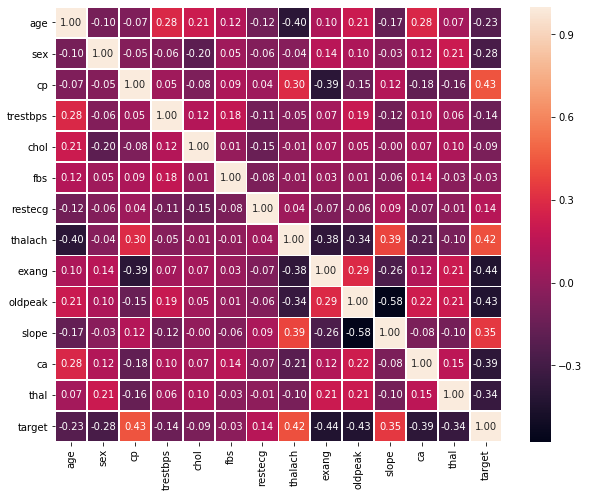

In [11]:
# 相関マトリックスの計算
corr = dfNorm.corr()

# ヒートマップのプロット
import seaborn as sns
fig = plt.figure(figsize=(10,8))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        annot=True,fmt='.2f',  # 係数の表示（小数点２位まで）
        linewidths=.75)

findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


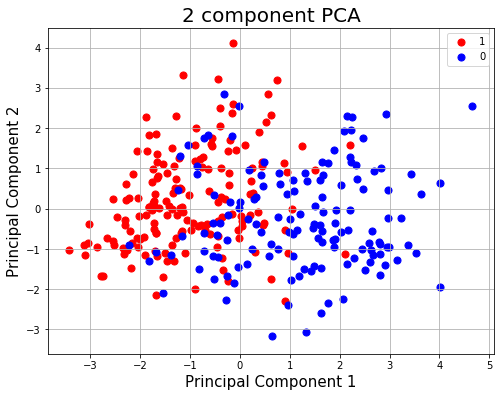

In [12]:
# 目的変数の主成分分析

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, df[['target']]], axis = 1)

fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [1,0]
colors = ['r',  'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

## 関数定義（検証指数および可視化関数）

In [122]:
# 機械学習 → 検証 → 結果表示関数
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
    
def confusion_matrix(model, y_val, y_pred): # 同じコードの重複を避けるため、関数を定義
    
    # confusion matrix（混合行列）表示
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_val, y_pred)
    print(cm)
    #acc = model.score(X_val, y_val)
    # 横軸が予想(predicted)、縦軸が実際(actual)
    #print("Open Accuracy:", acc)
    
    # 混合行列の描画
    sns.set()
    cm_rate = cm / cm.sum()
    labels = ["False","True"]
    fig = plt.figure(figsize=(5, 5))
    heatmap = sns.heatmap(
        cm_rate, xticklabels=labels, yticklabels=labels,
        annot=True, fmt='.1%', cbar=True, square=True, cmap='YlGnBu')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    # Generate a classification report
    report = classification_report(y_pred, y_val, target_names=['False','True'])
    print(report)
    return

## 各種分類器での学習

### lightGBM

In [17]:
lgbm.LGBMClassifier()

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [131]:
# https://www.kaggle.com/namakaho/nyctaxi
# https://www.kaggle.com/jsylas/top-ten-rank-r-22m-rows-2-90-lightgbm

params = {'boosting_type':'gbdt',
          'objective': 'binary', # 多クラス分類なら、multiclass
          'nthread': 4,
          'num_leaves': 31,
          'learning_rate': 0.034,
          'max_depth': -1,
          'subsample': 0.8,
          'bagging_fraction' : 1,
          'max_bin' : 5000 ,
          'bagging_freq': 20,
          'colsample_bytree': 0.6,
          'metric': 'acc',      # binary_error にすることもある
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 10,
          'scale_pos_weight':1,
          'zero_as_missing': True,
          'seed':128, # 0 から変更
          'num_rounds':50000}

In [127]:
lgbm_params = {
    # 二値分類問題
    'objective': 'binary',
    # AUC の最大化を目指す
    'metric': 'acc',
    #'metric': 'binary_error',
    'num_rounds':50000
}

In [133]:
gc.collect()

#train_set = lgbm.Dataset(X_train, y_train, silent=False)
#valid_set = lgbm.Dataset(X_val, y_val, silent=False)

train_set = lgbm.Dataset(X_train, y_train)
valid_set = lgbm.Dataset(X_val, y_val, reference=train_set)

#model = lgbm.train(params, train_set = train_set, num_boost_round=500,early_stopping_rounds=500,
#                   verbose_eval=500, valid_sets=valid_set)

model = lgbm.train(params, train_set, valid_sets=valid_set)

gc.collect()

37

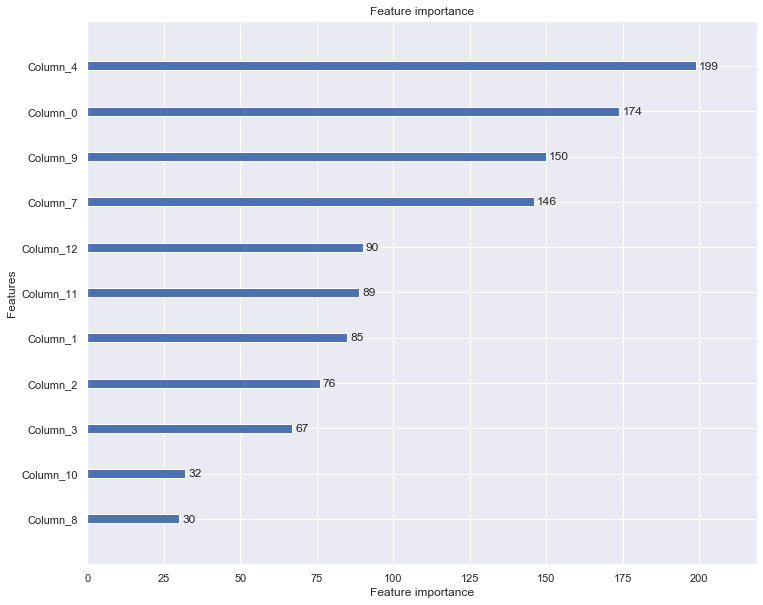

In [134]:
lgbm.plot_importance(model, figsize=(12, 10))

In [135]:
y_pred = model.predict(X_val, num_iteration=model.best_iteration)

In [136]:
y_train

array([1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0], dtype=int64)

In [137]:
y_val

array([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0], dtype=int64)

In [138]:
y_pred

array([0.11585862, 0.83503842, 0.44604136, 0.01757829, 0.20991155,
       0.39010559, 0.08980144, 0.04541808, 0.01131035, 0.03031466,
       0.71543952, 0.92541376, 0.07209472, 0.9458096 , 0.98171623,
       0.87669118, 0.11493557, 0.75451329, 0.03012264, 0.79254914,
       0.94283914, 0.29288917, 0.15185104, 0.13831057, 0.8905776 ,
       0.64535705, 0.08254559, 0.26482277, 0.9694254 , 0.86414448,
       0.62083651, 0.0576862 , 0.96957275, 0.9376065 , 0.9783265 ,
       0.75756574, 0.11195948, 0.8906407 , 0.12351958, 0.05180953,
       0.76342116, 0.48118931, 0.91273069, 0.14224791, 0.51580429,
       0.84638214, 0.88839825, 0.6205346 , 0.03442196, 0.82577594,
       0.92702298, 0.94063405, 0.975116  , 0.77112183, 0.98755071,
       0.12163753, 0.89335527, 0.90689059, 0.87432838, 0.97514504,
       0.89535539, 0.98690873, 0.89864192, 0.93509153, 0.90258366,
       0.77953812, 0.58116747, 0.06641977, 0.89691798, 0.86614401,
       0.40486473, 0.97058774, 0.93876541, 0.02721457, 0.18622

In [139]:
y_pred = np.round(y_pred)
y_pred

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
       1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1.,
       1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       1., 0., 1., 1., 1., 0.])

[[33 11]
 [ 5 42]]


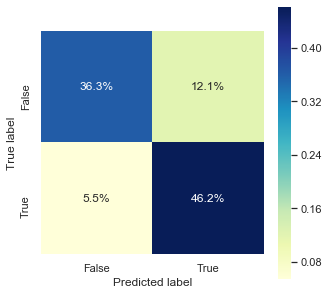

              precision    recall  f1-score   support

       False       0.75      0.87      0.80        38
        True       0.89      0.79      0.84        53

    accuracy                           0.82        91
   macro avg       0.82      0.83      0.82        91
weighted avg       0.83      0.82      0.83        91



In [140]:
confusion_matrix(model,y_val, y_pred) # 関数の呼び出し

In [ ]:
#roc_graph_cv(model, X_train, y_train) # 関数の呼び出し